# VISUALIZE SIMPLE MODELS PERFORMANCE

IMPORT REQUIRED LIBRARY

In [1]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.tree import export_text
import sys
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Add the path to the src directory to the path
notebooks_path = os.path.dirname(os.getcwd())
ml_puppils_path = os.path.dirname(notebooks_path)
src_path = os.path.join(ml_puppils_path, 'src')
sys.path.append(src_path)
import utils.utils as utils
import utils.testutils as testutils
import utils.dataloader as dataloader

IMG_SIZE = (256, 256)
IMAGE_COLUMNS= 4
IMAGE_ROWS = 1



DEFINE SOME SUPPORTED FUNCTIONS

In [2]:
def get_classified_items_statistic(y_true, y_pred):
    """Extract misclassified items with their predicted and true classes."""
    missclassified = [{}, {}, {}, {}]
    
    for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
            if pred_label not in missclassified[true_label]:
                missclassified[true_label][pred_label] = [i]
            else:
                missclassified[true_label][pred_label].append(i)
    return missclassified


In [3]:
def display_img(image_sample, classes):
    
    # Create a row of subplots with equal sizes
    fig, axes = plt.subplots(IMAGE_ROWS, IMAGE_COLUMNS, figsize=(10, 10))  

    # If only one image, axes is not iterable, so we convert it into a list
    if len(image_sample) == 1:
        axes = [axes]

    axes = axes.flatten()


    # Display images in a row
    for i, data in enumerate(image_sample):
        axes[i].imshow(data, cmap='gray')  # Show the image in grayscale
        axes[i].axis('off')  # Hide the axes
        axes[i].set_title(f"{classes[i]}")  # Title for each image

    for j in range(len(image_sample), 4):
        axes[j].axis('off')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show() # Show the plot

In [4]:
def get_result_statistic(image_dataset, y_true, y_preds, image_on=True):
    result_statistic = get_classified_items_statistic(y_true, y_preds)
    result_statistic_dict = []
    for i in range(4):
        print(f"Statistic about class {i}")
        statistic = {}
        statistic['true_quan'] = sum(y_true == i)
        class_result = result_statistic[i]
        pnegative = 0
        for key, value in class_result.items():
            if key == i:
                statistic['true_positive'] = len(value)
                print(f"Correctly classified as class {i}: {len(value)}")
                continue
            statistic[key] = len(value)
            pnegative += len(value)
            print(f"Missed classified objects that in class {key}: {len(value)}")
            if image_on:
                value = value[:4]
                value = [image_dataset[i] for i in value]
                display_img(value, [key]*len(value))
        statistic['false_positive_quan'] = pnegative
        result_statistic_dict.append(statistic)
        print(f"Total number of items for class in real dataset: {statistic['true_quan']}")
        print(f"Number of false positive: {statistic['false_positive_quan']} ~ {statistic['false_positive_quan']/statistic['true_quan']*100}%")
        print()
    return result_statistic_dict

In [5]:
def eval_model(model_arg, image=True):
    test_raw_path = os.path.join(src_path, 'dataset/raw/Testing')
    test_processed_path = os.path.join(src_path, 'dataset/processed/test.npz')
    saved_model = os.path.join(src_path, f'results/models/{model_arg}')
    model_path = utils.get_latest_model_path(saved_model)
    image_dataset = np.load(test_processed_path)
    try:
        model_module = importlib.import_module(f"models.{model_arg}")
        print("model module",model_module)
    except ModuleNotFoundError:
        raise ValueError(f"Model '{model_arg}' not found. Ensure there is a corresponding file in models/.")
    
    # Dynamically load train and evaluate functions
    eval_func = getattr(model_module, "evaluate", None)
    
    dataset = dataloader.get_dataset(test_raw_path, test_processed_path)
    image_dataset, y_true = dataset.images, dataset.labels
    y, y_preds, y_scores = eval_func((image_dataset, y_true), model_path, model_arg)
    print(testutils.metric_results(y, y_preds, y_scores, ["full"]))
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_preds, normalize='true')

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='f', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()
    return get_result_statistic(image_dataset, y_true, y_preds, image)

# GRADIENT BOOSTING

model module <module 'models.gradient_boosting' from '/Users/phuocpham/Desktop/ML/ml-pupils/src/models/gradient_boosting.py'>
Loaded saved dataset from /Users/phuocpham/Desktop/ML/ml-pupils/src/dataset/processed/test.npz
Model loaded from /Users/phuocpham/Desktop/ML/ml-pupils/src/results/models/gradient_boosting/xgboost_22052025_11-31-20.pkl
              precision    recall  f1-score   support

           0       0.65      0.84      0.73       300
           1       0.75      0.88      0.81       405
           2       0.67      0.58      0.62       300
           3       0.53      0.34      0.41       306

    accuracy                           0.67      1311
   macro avg       0.65      0.66      0.64      1311
weighted avg       0.66      0.67      0.66      1311



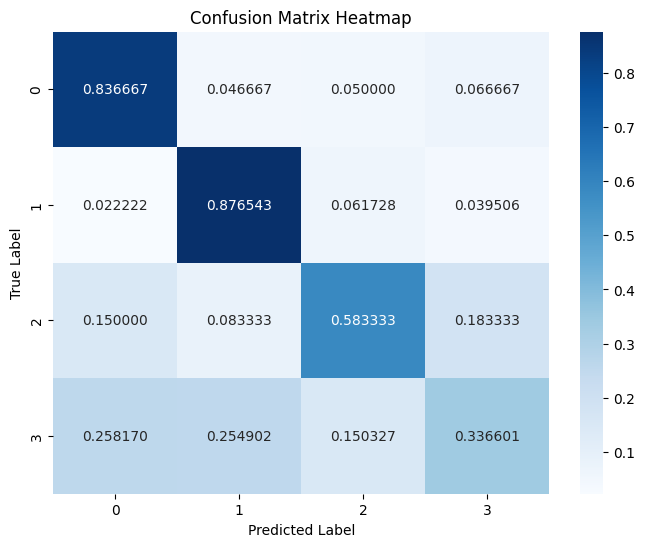

Statistic about class 0
Correctly classified as class 0: 251
Missed classified objects that in class 1: 14


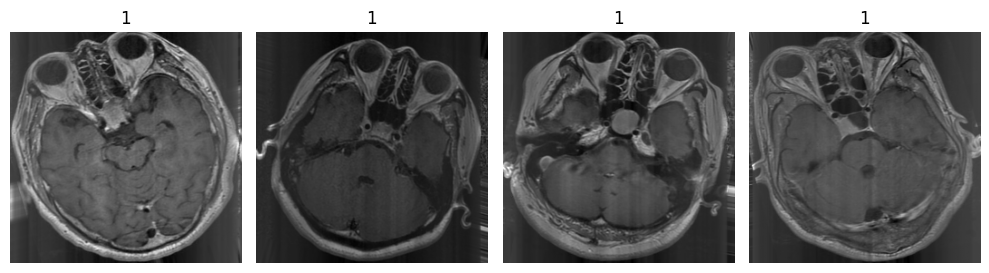

Missed classified objects that in class 3: 20


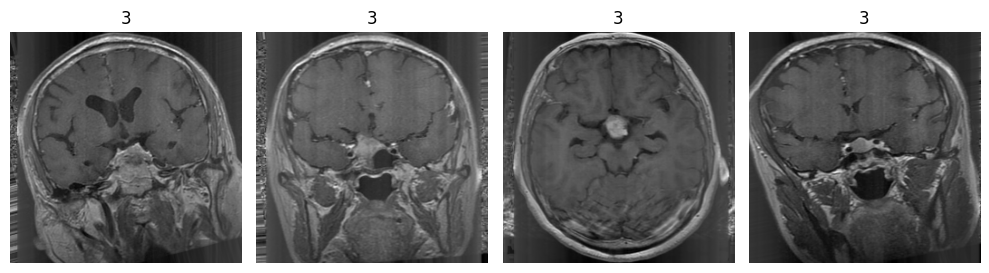

Missed classified objects that in class 2: 15


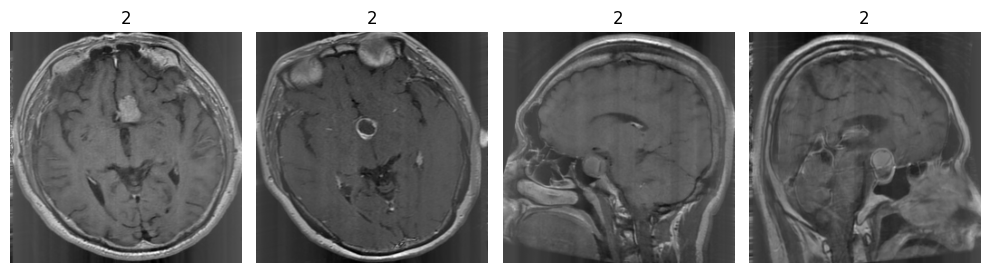

Total number of items for class in real dataset: 300
Number of false positive: 49 ~ 16.333333333333332%

Statistic about class 1
Correctly classified as class 1: 355
Missed classified objects that in class 3: 16


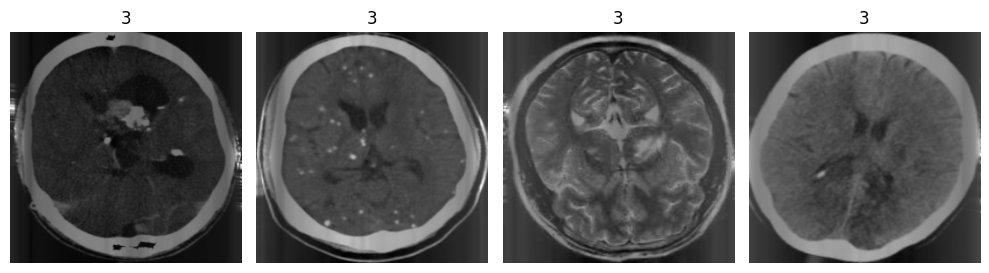

Missed classified objects that in class 2: 25


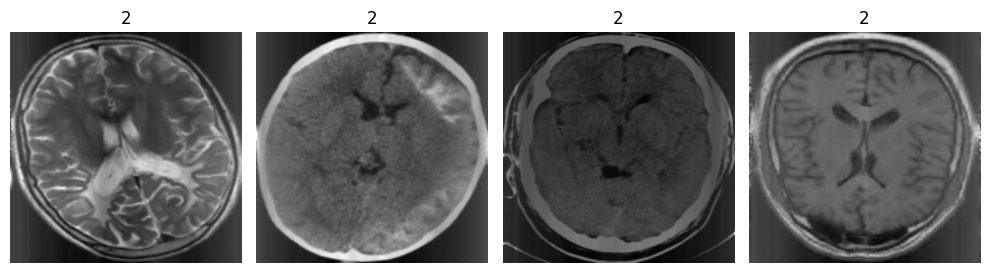

Missed classified objects that in class 0: 9


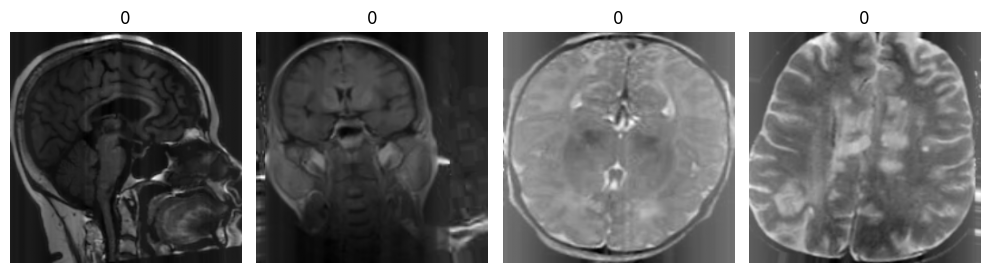

Total number of items for class in real dataset: 405
Number of false positive: 50 ~ 12.345679012345679%

Statistic about class 2
Missed classified objects that in class 3: 55


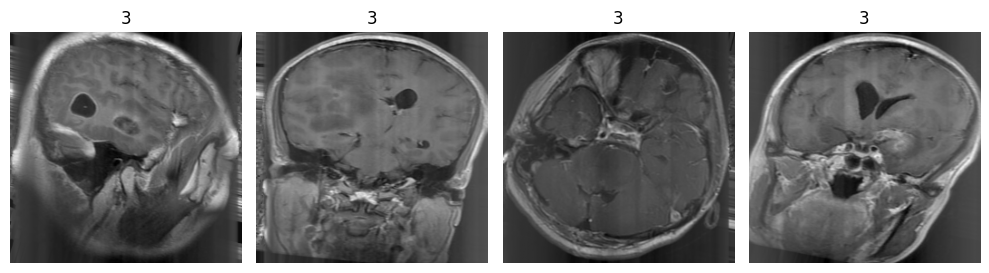

Correctly classified as class 2: 175
Missed classified objects that in class 0: 45


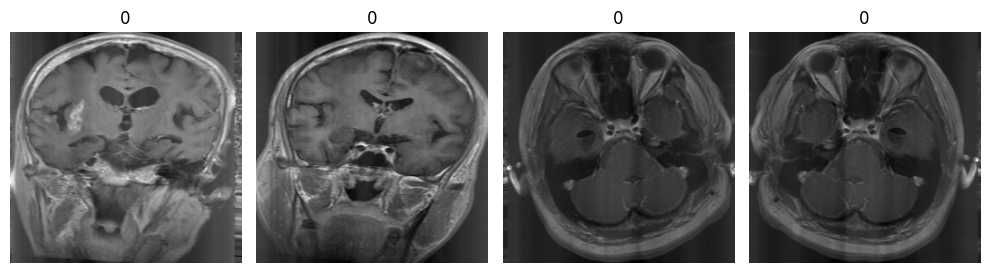

Missed classified objects that in class 1: 25


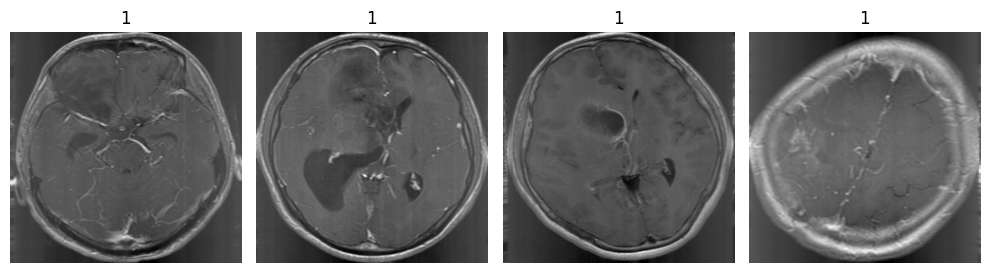

Total number of items for class in real dataset: 300
Number of false positive: 125 ~ 41.66666666666667%

Statistic about class 3
Missed classified objects that in class 0: 79


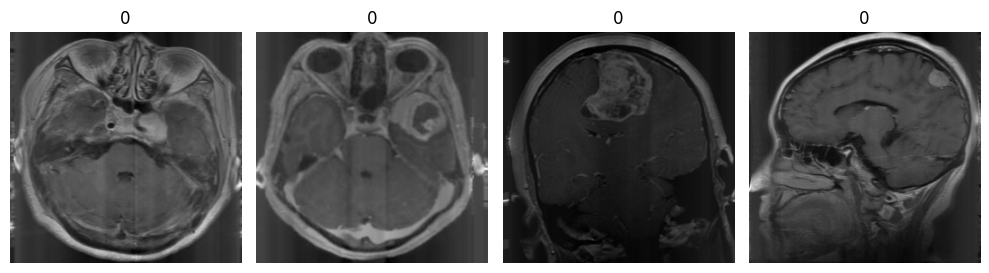

Missed classified objects that in class 1: 78


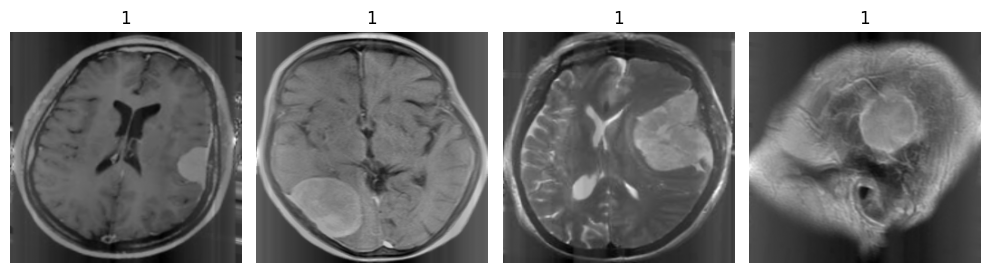

Correctly classified as class 3: 103
Missed classified objects that in class 2: 46


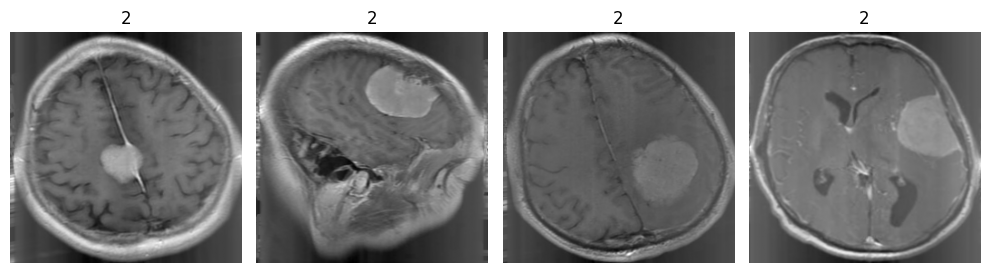

Total number of items for class in real dataset: 306
Number of false positive: 203 ~ 66.33986928104575%



[{'true_quan': np.int64(300),
  'true_positive': 251,
  np.int32(1): 14,
  np.int32(3): 20,
  np.int32(2): 15,
  'false_positive_quan': 49},
 {'true_quan': np.int64(405),
  'true_positive': 355,
  np.int32(3): 16,
  np.int32(2): 25,
  np.int32(0): 9,
  'false_positive_quan': 50},
 {'true_quan': np.int64(300),
  np.int32(3): 55,
  'true_positive': 175,
  np.int32(0): 45,
  np.int32(1): 25,
  'false_positive_quan': 125},
 {'true_quan': np.int64(306),
  np.int32(0): 79,
  np.int32(1): 78,
  'true_positive': 103,
  np.int32(2): 46,
  'false_positive_quan': 203}]

In [6]:
eval_model('gradient_boosting', image=True)

#### Model Overview

XGBoost is a scalable and efficient gradient boosting framework. The model is tailored for multiclass classification, distinguishing between four tumor categories. We leveraged automated hyperparameter optimization via Hyperopt using the Tree-structured Parzen Estimator (TPE) algorithm to fine-tune model performance.

#### Data Preparation

MRI image data were reshaped into 2D feature vectors, with each sample flattened to ensure compatibility with XGBoost’s tree-based architecture. Corresponding tumor labels served as the target variable. The dataset was split into training and validation sets using stratified random sampling to maintain class distribution.

#### Hyperparameter Optimization

To optimize the learning process, we defined a search space over several key hyperparameters, including max_depth, learning_rate, gamma, reg_alpha, reg_lambda, colsample_bytree, min_child_weight, and subsample. Hyperopt evaluated model performance using the validation accuracy as the objective metric, employing early stopping to prevent overfitting. The best hyperparameters discovered were stored and reused for final model training.

#### Model Training and Evaluation

After identifying the optimal hyperparameters, we retrained the model with early stopping on the validation split to determine the best number of boosting rounds (n_estimators). A final model was then trained on the entire dataset using this optimal configuration. Throughout the process, model performance was monitored using the multi-class log loss (mlogloss) metric.

#### Overall Model Performance

The current XGBoost model demonstrates moderate performance (overall accuracy: 68%, macro F1-score: 0.64) in classifying brain tumor types from MRI features. It shows strong predictive ability for certain tumor types (especially Class 1), but struggles significantly with others (particularly Class 3, with an F1-score of 0.37), likely due to overlapping visual features or limited discriminatory power in the input data.

#### Use case fit conclusion
XGBoost would perform more effectively on structured data derived from images—such as radiomics features (e.g., shape, edge sharpness, contrast), clinical metadata, or segmentation-derived metrics. These high-level descriptors align well with XGBoost’s strength in handling heterogeneous, tabular features.

Well-suited for:

- Preprocessed, structured feature sets extracted from MRI images (e.g., radiomics or handcrafted features).

- Tabular datasets combining clinical, genomic, and imaging-derived summaries.

- Situations with limited image data, where CNNs may overfit but tree models can generalize better from fewer samples.

Not well-suited for:

- Raw pixel-based MRI classification without spatial modeling.

- Complex image classification tasks requiring understanding of shape, context, and relative position (e.g., differentiating tumors with similar intensity but different location).

- Applications where convolutional neural networks (CNNs) or hybrid deep learning models would be more appropriate.